# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# !pip install lightgbm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
prefilter_items

<function src.utils.prefilter_items(data, take_n_popular=5000, item_features=None)>

In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
from src.recommenders import MainRecommender
MainRecommender

src.recommenders.MainRecommender

In [7]:
recommender = MainRecommender(data_train_lvl_1)

In [8]:
recommender.get_als_recommendations(2375, N=200);

In [9]:
recommender.get_own_recommendations(2375, N=200);

In [10]:
recommender.get_similar_items_recommendation(2375, N=200);

In [11]:
recommender.get_similar_users_recommendation(2375, N=200)
pass

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [12]:

train_users = data_train_lvl_1['user_id'].unique() 

result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.loc[result_lvl_1.user_id.isin(train_users)]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [19]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 200))
result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], k=200), axis=1)
result_lvl_1['own_recall'].mean()


0.13537278412833242

In [14]:
result_lvl_1['als_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))
result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_candidates'], row['actual'], k=200), axis=1)
result_lvl_1['als_recall'].mean()


0.09752632759399278

In [15]:
result_lvl_1['similar_item_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, 200))
result_lvl_1['similar_item_recall'] = result_lvl_1.apply(lambda row:recall_at_k(row['similar_item_candidates'], row['actual'], k=200), axis=1)
result_lvl_1['similar_item_recall'].mean()


0.0861548105042518

Максимальный результат дала функция get_own_recommendations

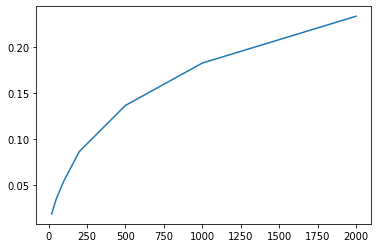

CPU times: user 4min 13s, sys: 16.9 s, total: 4min 30s
Wall time: 2min 27s


In [41]:
%%time
k = [20, 50, 100, 200, 500, 1000, 2000]
k_recall = []

for i in k:
    result_lvl_1[f'similar_items_recs_{i}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=i))
    k_recall_i = result_lvl_1.apply(lambda row: recall_at_k(row[f'similar_items_recs_{i}'], row['actual'], k=i), axis=1).mean()
    k_recall.append(k_recall_i)

plt.plot(k, k_recall)
plt.show()

In [42]:
k_recall[:1]

[0.01831407555102519]

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [27]:
result_lvl_1.head(2)

,user_id,actual,own_candidates,own_recall,als_candidates,als_recall,similar_item_candidates,similar_item_recall,als_recommendations,own_recommendations,similar_items_recs_20,similar_items_recs_50,similar_items_recs_100,similar_items_recs_200,similar_items_recs_500,similar_items_recs_1000
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...",0.247706,"[1037332, 1082212, 1062572, 885290, 856942, 10...",0.137615,"[824758, 826597, 9297615, 5577022, 9803207, 98...",0.110092,"[1037332, 1082212, 1062572, 885290, 856942, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 826597, 9297615, 5577022, 9803207, 98...","[824758, 826597, 9297615, 5577022, 9803207, 98...","[824758, 826597, 9297615, 5577022, 9803207, 98...","[824758, 826597, 9297615, 5577022, 9803207, 98...","[824758, 826597, 9297615, 5577022, 9803207, 98...","[824758, 826597, 9297615, 5577022, 9803207, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...",0.121622,"[916122, 5569230, 865528, 1029743, 919534, 866...",0.081081,"[8090537, 5569845, 1044078, 985999, 880888, 81...",0.094595,"[916122, 5569230, 865528, 1029743, 919534, 866...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81..."


In [28]:
data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [43]:
result_lvl_1['als_precision'] = result_lvl_1.apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=200), axis=1)
als_candidates = result_lvl_1[['user_id', 'als_candidates']]
als_candidates.head()

,user_id,als_candidates
0,1,"[1037332, 1082212, 1062572, 885290, 856942, 10..."
1,2,"[916122, 5569230, 865528, 1029743, 919534, 866..."
2,4,"[1091383, 821741, 891423, 6391541, 1082627, 84..."
3,6,"[933637, 1026118, 1084036, 1098248, 965267, 87..."
4,7,"[1039627, 974250, 10285022, 6533878, 5572220, ..."


In [46]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(als_candidates, on='user_id', how='left')
valid_lvl_2.head(2)

,user_id,actual,als_candidates
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1037332, 1082212, 1062572, 885290, 856942, 10..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN


In [47]:
valid_lvl_2[valid_lvl_2.als_candidates.notna()].apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=5), axis=1).mean()

0.09890339425587442

In [49]:
users_lvl_2 = pd.DataFrame(result_lvl_1['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))

s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(2)

,user_id,item_id,flag
0,1,1037332,1
0,1,1082212,1


In [50]:
data_train_lvl_2 = data_val_lvl_1.copy()
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [51]:

price = data.groupby('item_id')['sales_value'].max()
item_features = item_features.merge(price, on='item_id', how='left').rename(columns={'sales_value': 'price'})



In [52]:
avg_price_by_cat = item_features.groupby('commodity_desc')['price'].mean()
item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left').rename(columns={'price_x': 'price', 'price_y': 'avg_price'})

In [53]:
basket_price = data.groupby('basket_id')['sales_value'].sum()
data = data.merge(basket_price, on='basket_id', how='left').rename(columns={'sales_value_x': 'sales_value', 'sales_value_y': 'basket_price'})
avg_basket_per_user = data.groupby('user_id').basket_price.mean()
user_features = user_features.merge(avg_basket_per_user, on='user_id', how='left')


In [54]:
x = data.groupby(['user_id', 'week_no']).basket_id.count().reset_index().groupby('user_id').agg(['count', 'sum'])
x.columns = x.columns.droplevel(0)
avg_purchases_per_week = x.iloc[:, 2:].apply(lambda row: row['sum']/row['count'], axis=1)
avg_purchases_per_week.name = 'avg_purchases_per_week'
user_features = user_features.merge(avg_purchases_per_week, on='user_id', how='left')



In [55]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,basket_price,avg_purchases_per_week
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,77.419817,24.828125
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,86.418470,24.363636
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,82.333861,26.409091


In [56]:
item_features_copy = item_features[['item_id',
                                    'manufacturer',
                                    'department',
                                    'brand',
                                    'commodity_desc',
                                    'price',
                                    'avg_price']]

user_features_copy = user_features[['user_id',
                                    'age_desc',
                                    'income_desc',
                                    'household_size_desc',
                                    'avg_purchases_per_week',
                                    'basket_price']]

targets_lvl_2 = targets_lvl_2.merge(item_features_copy, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_copy, on='user_id', how='left')

targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,price,avg_price,age_desc,income_desc,household_size_desc,avg_purchases_per_week,basket_price
0,1,1037332,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,9.56,3.227402,65+,35-49K,2,24.828125,77.419817
1,1,1082212,1.0,1102,GROCERY,National,BAKED BREAD/BUNS/ROLLS,4.98,3.263789,65+,35-49K,2,24.828125,77.419817
2,1,1062572,0.0,586,GROCERY,National,CRACKERS/MISC BKD FD,10.72,3.513778,65+,35-49K,2,24.828125,77.419817
3,1,885290,0.0,910,GROCERY,National,BAKED BREAD/BUNS/ROLLS,7.47,3.263789,65+,35-49K,2,24.828125,77.419817
4,1,856942,1.0,159,GROCERY,National,BAKED BREAD/BUNS/ROLLS,15.00,3.263789,65+,35-49K,2,24.828125,77.419817


In [58]:

X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

cat = ['manufacturer',
               'department',
               'brand',
               'commodity_desc',
               'age_desc',
               'income_desc',
               'household_size_desc']

X_train[cat] = X_train[cat].astype('category')

In [73]:

lgb = LGBMClassifier(objective='binary', max_depth=5, num_leaves=20, categorical_feature=cat)
lgb.fit(X_train, y_train.values)

train_preds = lgb.predict_proba(X_train)[:, 1]

/Users/daniilstv/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/Users/daniilstv/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [74]:
targets_lvl_2['preds'] = train_preds
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)
lgb_candidates = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
lgb_candidates.head()


,user_id,item_id
0,1,"[1082269, 8293439, 9803545]"
1,2,"[1029743, 1106523, 1070820, 899624, 1044078]"
2,4,"[1029743, 983584, 883932, 5568378]"
3,6,"[1082185, 1106523, 899624, 1022254]"
4,7,"[1106523, 1126899, 916122, 1006483, 5585510]"


In [75]:
valid_lvl_2 = valid_lvl_2.merge(lgb_candidates, on='user_id', how='left')
valid_lvl_2.rename(columns={'item_id': 'lgb_candidates'}, inplace=True)
valid_lvl_2[valid_lvl_2.als_candidates.notna()].apply(lambda row: precision_at_k(row['lgb_candidates'], row['actual'], k=5), axis=1).mean()


0.18753698868581256

In [71]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', cate

In [ ]:
Использовались работы: mmingalov, Nafanjia, brabus72, carbon2409

https://github.com/mmingalov/geekbrains-recommend-systems/blob/829b2119598c87049b30e8c21296a7b602839523/hw_webinar_6.ipynb
https://github.com/Nafanjia/Recommendation-systems/blob/257118ae2ad301dde89f581fb09f4a94d8b5ce04/RS_6.ipynb
https://github.com/brabus72/Recomm_Sys/blob/c7af318e79c62ec2c9908cfd7e3624f3e7427521/RS_hw6.ipynb
https://github.com/carbon2409/recommended_system/blob/0d5f26d38b503392d3650182c0dabd46d18fe3a3/Lesson_6/Nizamov_hw_webinar_6.ipynb

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)